In [1]:
from google.colab import files
uploaded = files.upload()

Saving tubes2.zip to tubes2.zip


In [2]:
!unzip -o tubes2.zip

Archive:  tubes2.zip
   creating: src/
   creating: src/core/
  inflating: src/core/layer.py       
  inflating: src/core/tensor.py      
  inflating: src/core/__init__.py    
   creating: src/core/__pycache__/
  inflating: src/core/__pycache__/layer.cpython-310.pyc  
  inflating: src/core/__pycache__/layer.cpython-313.pyc  
  inflating: src/core/__pycache__/sequential.cpython-313.pyc  
  inflating: src/core/__pycache__/tensor.cpython-310.pyc  
  inflating: src/core/__pycache__/tensor.cpython-313.pyc  
  inflating: src/core/__pycache__/__init__.cpython-310.pyc  
  inflating: src/core/__pycache__/__init__.cpython-313.pyc  
   creating: src/functions/
  inflating: src/functions/activation.py  
  inflating: src/functions/loss.py   
  inflating: src/functions/__init__.py  
   creating: src/functions/__pycache__/
  inflating: src/functions/__pycache__/activation.cpython-310.pyc  
  inflating: src/functions/__pycache__/activation.cpython-313.pyc  
  inflating: src/functions/__pycache__/loss.

In [3]:
import sys
sys.path.append('/content')

In [4]:
!pip install tensorflow numpy

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import h5py
import os
import tempfile

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D as KerasConv2D, MaxPooling2D as KerasMaxPooling2D
from tensorflow.keras.layers import AveragePooling2D as KerasAveragePooling2D, GlobalAveragePooling2D as KerasGlobalAvgPool
from tensorflow.keras.layers import Flatten as KerasFlatten, Dense as KerasDense
from tensorflow.keras.layers import Input as KerasInput, ReLU as KerasReLU_Layer, Softmax as KerasSoftmax_Layer
from tensorflow.keras.models import Sequential as KerasSequentialModel
from tensorflow.keras.datasets import cifar10
from typing import List, Tuple, Dict, Optional

from src.core import Tensor, Layer
from src.functions import ActivationFunction, Linear, ReLU, Sigmoid, Softmax, LossFunction, MeanSquaredError, CategoricalCrossEntropy, BinaryCrossEntropy
from src.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from src.model import Sequential
from src.optimization import Optimizer, Adam
from src.tests import TestCNNLayer, TestCNNModel, TestLoadKerasWeights
from src.utils import _calculate_padding_2d, _calculate_pooling_output_dims, convolve2d, numerical_gradient_array

In [ ]:
def load_and_preprocess_cifar10_with_validation_split():
    (x_train_full, y_train_full_raw), (x_test_keras, y_test_raw) = cifar10.load_data()
    print(f"Original x_train_full shape: {x_train_full.shape}, y_train_full_raw shape: {y_train_full_raw.shape}")
    print(f"Original x_test shape: {x_test_keras.shape}, y_test_raw shape: {y_test_raw.shape}")

    x_train_full_norm = x_train_full.astype('float32') / 255.0
    x_test_keras_norm = x_test_keras.astype('float32') / 255.0

    y_train_full_labels = y_train_full_raw.squeeze()
    y_test_labels = y_test_raw.squeeze()

    x_train_keras, x_val_keras, y_train_labels, y_val_labels = train_test_split(
        x_train_full_norm, y_train_full_labels, test_size=0.2, random_state=42, stratify=y_train_full_labels # 10k for val
    )
    print(f"Keras train shape: {x_train_keras.shape}, Keras val shape: {x_val_keras.shape}, Keras test shape: {x_test_keras_norm.shape}")
    print(f"Keras y_train_labels shape: {y_train_labels.shape}, y_val_labels shape: {y_val_labels.shape}, y_test_labels shape: {y_test_labels.shape}")

    x_train_custom = np.transpose(x_train_keras, (0, 3, 1, 2))
    x_val_custom = np.transpose(x_val_keras, (0, 3, 1, 2))
    x_test_custom = np.transpose(x_test_keras_norm, (0, 3, 1, 2))

    num_classes = 10

    return (x_train_keras, y_train_labels, x_val_keras, y_val_labels, x_test_keras_norm, y_test_labels,
            x_train_custom, x_val_custom, x_test_custom, # y_train_one_hot, y_val_one_hot, y_test_one_hot,
            num_classes)

In [ ]:
(x_train_k_fmt, y_train_int, x_val_k_fmt, y_val_int, x_test_k_fmt, y_test_int,
  x_train_c_fmt, x_val_c_fmt, x_test_c_fmt,
  NUM_CLASSES_EXP) = load_and_preprocess_cifar10_with_validation_split()

INPUT_CHANNELS_EXP = x_train_c_fmt.shape[1]
INPUT_SHAPE_KERAS_EXP = (x_train_k_fmt.shape[1], x_train_k_fmt.shape[2], x_train_k_fmt.shape[3])

Original x_train_full shape: (50000, 32, 32, 3), y_train_full_raw shape: (50000, 1)
Original x_test shape: (10000, 32, 32, 3), y_test_raw shape: (10000, 1)
Keras train shape: (40000, 32, 32, 3), Keras val shape: (10000, 32, 32, 3), Keras test shape: (10000, 32, 32, 3)
Keras y_train_labels shape: (40000,), y_val_labels shape: (10000,), y_test_labels shape: (10000,)


In [ ]:
def run_keras_experiment_variant(
    keras_model_builder_fn,
    model_variant_name: str,
    keras_input_shape_val: Tuple,
    num_classes_val: int,
    x_train_data: np.ndarray, y_train_labels_data: np.ndarray,
    x_val_data: np.ndarray, y_val_labels_data: np.ndarray,
    x_test_data: np.ndarray, y_test_labels_data: np.ndarray,
    epochs_val: int, batch_size_val: int):

    print(f"\n--- Running Keras Experiment Variant: {model_variant_name} ---")

    keras_model = keras_model_builder_fn(keras_input_shape_val, num_classes_val)

    keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

    print(f"Training Keras model: {model_variant_name}...")
    start_train_time = time.time()
    keras_history = keras_model.fit(
        x_train_data, y_train_labels_data,
        epochs=epochs_val,
        batch_size=batch_size_val,
        validation_data=(x_val_data, y_val_labels_data),
        verbose=1
    )
    train_duration = time.time() - start_train_time
    print(f"Keras training for {model_variant_name} took {train_duration:.2f}s.")

    # Evaluate Keras model on the Test Set
    print(f"\nEvaluating Keras Model: {model_variant_name} on Test Set")
    test_loss_k, test_accuracy_k = keras_model.evaluate(x_test_data, y_test_labels_data,
                                                        batch_size=batch_size_val, verbose=0)

    predictions_test_k_probs = keras_model.predict(x_test_data, batch_size=batch_size_val)
    predicted_classes_test_k = np.argmax(predictions_test_k_probs, axis=1)

    test_f1_macro_k = f1_score(y_test_labels_data, predicted_classes_test_k, average='macro', zero_division=0)

    print(f"Keras Test Loss: {test_loss_k:.4f}")
    print(f"Keras Test Accuracy: {test_accuracy_k*100:.2f}%")
    print(f"Keras Test F1-score (Macro): {test_f1_macro_k:.4f}")

    # Plot Keras training history
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Keras Model Training - {model_variant_name}", fontsize=14)
    plt.subplot(1, 2, 1)
    plt.plot(keras_history.history['loss'], label='Training Loss')
    plt.plot(keras_history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(keras_history.history['accuracy'], label='Training Accuracy')
    plt.plot(keras_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return keras_model, {"loss": test_loss_k, "accuracy": test_accuracy_k, "f1_macro": test_f1_macro_k}

In [ ]:
EPOCHS_ALL_EXP = 15
BATCH_SIZE_ALL_EXP = 64
FIXED_SEED_ALL_EXP = 42

all_keras_experiment_results = {}
last_keras_model_trained = None 

## Eksperimen 1: Pengaruh Jumlah Layer Konvolusi

In [ ]:
def create_keras_model_conv_depth_exp1(input_shape_hwc, num_classes_val, conv_blocks_count):
    layers_k = [KerasInput(shape=input_shape_hwc, name="input_exp1")]
    current_filters = 32
    for i in range(conv_blocks_count):
        layers_k.extend([
            KerasConv2D(current_filters, (3,3), padding='same', activation='relu', name=f"k_block{i+1}_conv1"),
            KerasConv2D(current_filters, (3,3), padding='same', activation='relu', name=f"k_block{i+1}_conv2"),
            KerasMaxPooling2D((2,2), name=f"k_block{i+1}_pool")
        ])
        if i < 2 :
             current_filters *= 2

    layers_k.extend([
        KerasGlobalAvgPool(name="k_global_avg_pool") if conv_blocks_count >=3 else KerasFlatten(name="k_flatten"),
        KerasDense(128, activation='relu', name="k_dense1"),
        KerasDense(num_classes_val, activation='softmax', name="k_output_dense")
    ])
    return KerasSequentialModel(layers_k, name=f"keras_conv_depth_{conv_blocks_count}")



--- Running Keras Experiment Variant: 2_ConvLayers_1_Blocks ---
Training Keras model: 2_ConvLayers_1_Blocks...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3997 - loss: 1.6661 - val_accuracy: 0.5927 - val_loss: 1.1631
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6127 - loss: 1.1119 - val_accuracy: 0.6387 - val_loss: 1.0432
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6791 - loss: 0.9270 - val_accuracy: 0.6550 - val_loss: 0.9932
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7244 - loss: 0.7960 - val_accuracy: 0.6533 - val_loss: 1.0286
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7608 - loss: 0.6888 - val_accuracy: 0.6567 - val_loss: 1.0344
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7983 - loss: 0.5914 - val_accuracy: 0.6487 - val_loss: 1.1156
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8270 - loss: 0.5055 - val_accuracy: 0.6355 - val_loss:

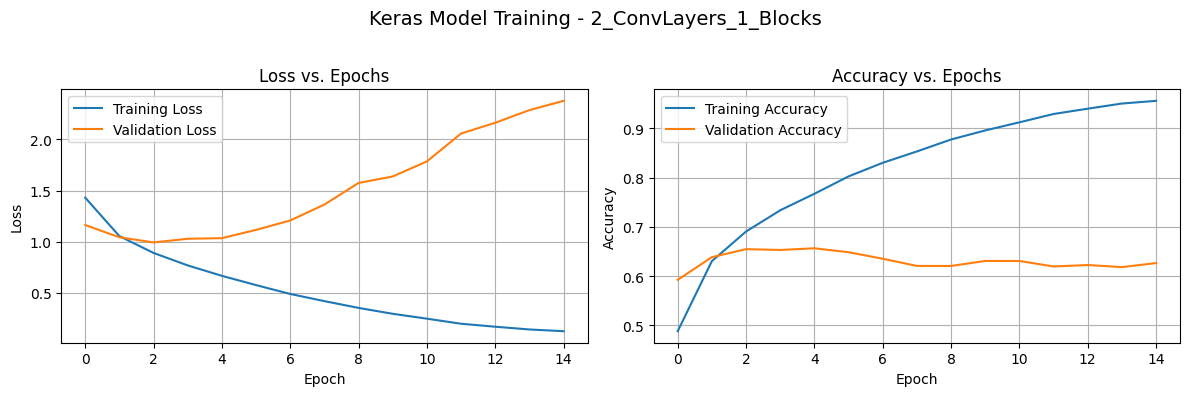


--- Running Keras Experiment Variant: 4_ConvLayers_2_Blocks ---
Training Keras model: 4_ConvLayers_2_Blocks...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3336 - loss: 1.8052 - val_accuracy: 0.5532 - val_loss: 1.2438
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5744 - loss: 1.1927 - val_accuracy: 0.6445 - val_loss: 1.0284
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6665 - loss: 0.9562 - val_accuracy: 0.6750 - val_loss: 0.9408
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7214 - loss: 0.8008 - val_accuracy: 0.6832 - val_loss: 0.9351
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7560 - loss: 0.7035 - val_accuracy: 0.6931 - val_loss: 0.9161
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7821 - loss: 0.6176 - val_accuracy: 0.6949 - val_loss: 0.9555
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8091 - loss: 0.5397 - val_accuracy: 0.7045 - val_loss:

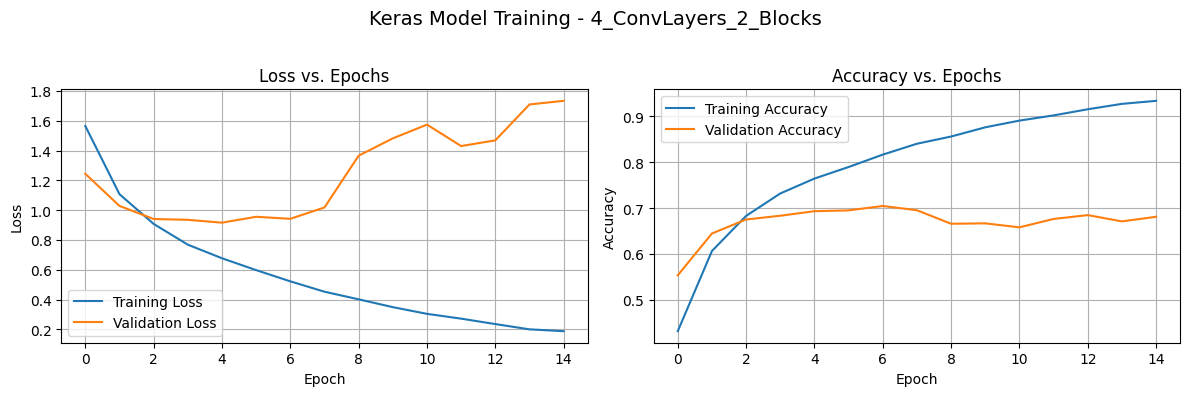


--- Running Keras Experiment Variant: 6_ConvLayers_3_Blocks ---
Training Keras model: 6_ConvLayers_3_Blocks...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.2306 - loss: 1.9775 - val_accuracy: 0.4475 - val_loss: 1.4749
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4891 - loss: 1.3862 - val_accuracy: 0.5898 - val_loss: 1.1263
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5897 - loss: 1.1273 - val_accuracy: 0.6629 - val_loss: 0.9391
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6621 - loss: 0.9463 - val_accuracy: 0.7043 - val_loss: 0.8439
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7128 - loss: 0.8199 - val_accuracy: 0.7229 - val_loss: 0.8000
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7477 - loss: 0.7256 - val_accuracy: 0.7308 - val_loss: 0.7887
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7782 - loss: 0.6442 - val_accuracy: 0.7267 - val_los

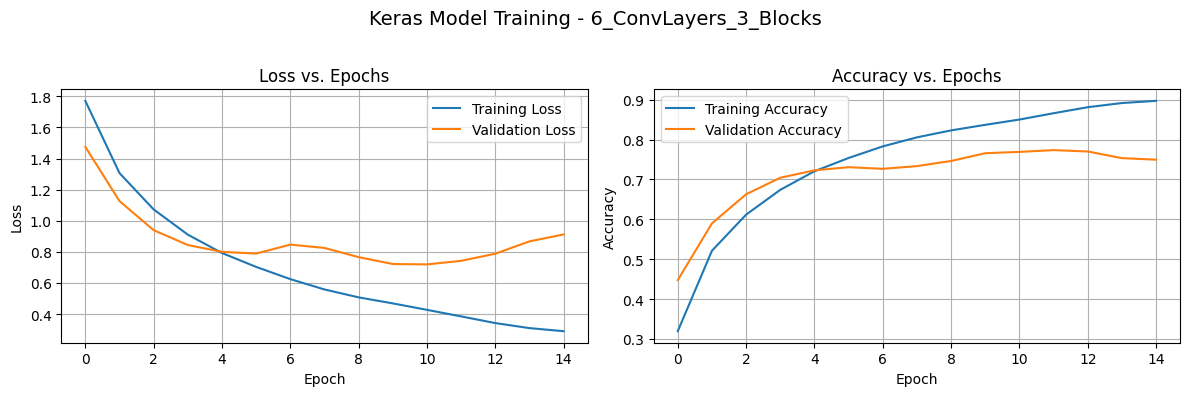

In [70]:
all_keras_experiment_results["conv_depth"] = {}
conv_block_configs = [1, 2, 3]

for num_blocks in conv_block_configs:
    model_name = f"{num_blocks*2}_ConvLayers_{num_blocks}_Blocks"

    keras_builder_fn = lambda inp_s, n_cls: create_keras_model_conv_depth_exp1(inp_s, n_cls, num_blocks)

    trained_k_model, metrics_k = run_keras_experiment_variant(
        keras_model_builder_fn=keras_builder_fn,
        model_variant_name=model_name,
        keras_input_shape_val=INPUT_SHAPE_KERAS_EXP,
        num_classes_val=NUM_CLASSES_EXP,
        x_train_data=x_train_k_fmt, y_train_labels_data=y_train_int,
        x_val_data=x_val_k_fmt, y_val_labels_data=y_val_int,
        x_test_data=x_test_k_fmt, y_test_labels_data=y_test_int,
        epochs_val=EPOCHS_ALL_EXP, batch_size_val=BATCH_SIZE_ALL_EXP
    )
    all_keras_experiment_results["conv_depth"][model_name] = metrics_k
    if num_blocks == conv_block_configs[-1]:
        last_keras_model_trained = trained_k_model

In [71]:
print("\n--- Hasil Eksperimen 1: Jumlah Layer Konvolusi ---")
if "conv_depth" in all_keras_experiment_results:
  for model_name, result_metrics in all_keras_experiment_results["conv_depth"].items():
    print(f"Keras Model: {model_name}")
    print(f"  Test F1-Macro: {result_metrics['f1_macro']:.4f}")
    print(f"  Test Accuracy: {result_metrics['accuracy']*100:.2f}%")


--- Hasil Eksperimen 1: Jumlah Layer Konvolusi ---
Keras Model: 2_ConvLayers_1_Blocks
  Test F1-Macro: 0.6213
  Test Accuracy: 62.24%
Keras Model: 4_ConvLayers_2_Blocks
  Test F1-Macro: 0.6814
  Test Accuracy: 68.03%
Keras Model: 6_ConvLayers_3_Blocks
  Test F1-Macro: 0.7430
  Test Accuracy: 74.19%


## Eksperimen 2: Banyak Filter per Layer Konvolusi

In [77]:
def create_keras_model_filter_config_exp2(input_shape_hwc, num_classes_val, filter_config_list_of_tuples):
    layers_k = [KerasInput(shape=input_shape_hwc, name="input_exp2")]

    for i, (f1, f2) in enumerate(filter_config_list_of_tuples):
        block_id = i + 1
        layers_k.extend([
            KerasConv2D(f1, (3,3), padding='same', activation='relu', name=f"k_exp2_b{block_id}_conv1"),
            KerasConv2D(f2, (3,3), padding='same', activation='relu', name=f"k_exp2_b{block_id}_conv2"),
            KerasMaxPooling2D((2,2), name=f"k_exp2_b{block_id}_pool")
        ])

    layers_k.extend([
        KerasFlatten(name="k_exp2_flatten"),
        KerasDense(128, activation='relu', name="k_exp2_dense1"),
        KerasDense(num_classes_val, activation='softmax', name="k_exp2_output_dense")
    ])
    model_name_suffix = '_'.join([f"{fc[0]}-{fc[1]}" for fc in filter_config_list_of_tuples])
    return KerasSequentialModel(layers_k, name=f"keras_filters_{model_name_suffix}")


--- Running Keras Experiment Variant: Filters_Var1_16-16_32-32 ---
Training Keras model: Filters_Var1_16-16_32-32...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3480 - loss: 1.7691 - val_accuracy: 0.5738 - val_loss: 1.1899
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5830 - loss: 1.1784 - val_accuracy: 0.6574 - val_loss: 0.9948
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6625 - loss: 0.9674 - val_accuracy: 0.6761 - val_loss: 0.9308
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7091 - loss: 0.8402 - val_accuracy: 0.6871 - val_loss: 0.9152
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7424 - loss: 0.7450 - val_accuracy: 0.6951 - val_loss: 0.9102
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7731 - loss: 0.6612 - val_accuracy: 0.7008 - val_loss: 0.9306
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7949 - loss: 0.5971 - val_accuracy: 0.7054 - val

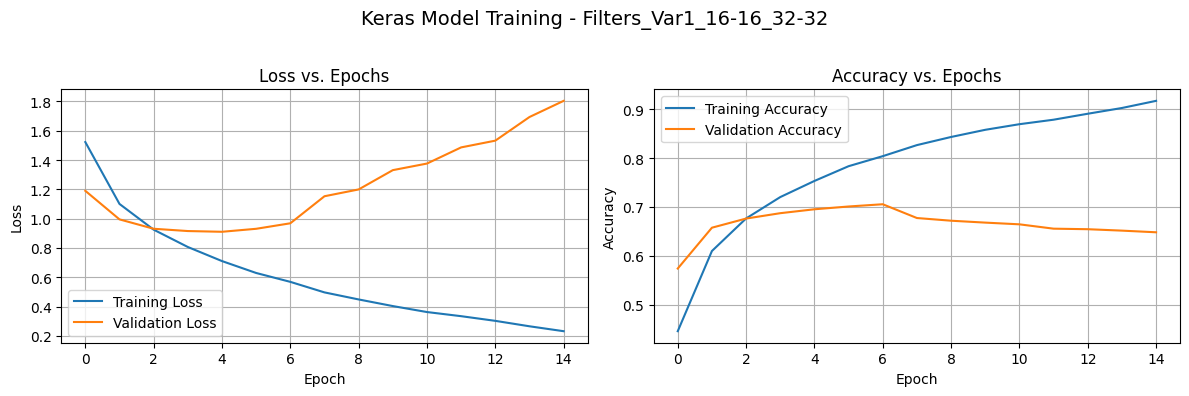


--- Running Keras Experiment Variant: Filters_Var2_32-32_64-64 ---
Training Keras model: Filters_Var2_32-32_64-64...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3595 - loss: 1.7343 - val_accuracy: 0.6071 - val_loss: 1.1035
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6158 - loss: 1.0853 - val_accuracy: 0.6684 - val_loss: 0.9573
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6954 - loss: 0.8702 - val_accuracy: 0.6939 - val_loss: 0.8861
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7479 - loss: 0.7243 - val_accuracy: 0.7045 - val_loss: 0.8808
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7870 - loss: 0.6098 - val_accuracy: 0.7159 - val_loss: 0.8693
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8234 - loss: 0.5131 - val_accuracy: 0.7033 - val_loss: 0.9572
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8426 - loss: 0.4501 - val_accuracy: 0.6916 - val

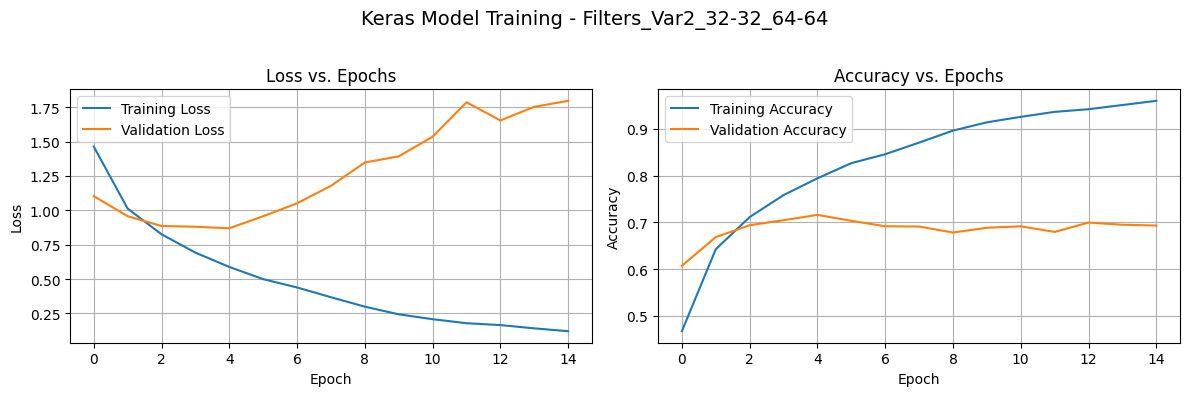


--- Running Keras Experiment Variant: Filters_Var3_64-64_128-128 ---
Training Keras model: Filters_Var3_64-64_128-128...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3591 - loss: 1.7429 - val_accuracy: 0.6127 - val_loss: 1.1204
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6381 - loss: 1.0351 - val_accuracy: 0.7003 - val_loss: 0.8656
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7231 - loss: 0.7979 - val_accuracy: 0.7202 - val_loss: 0.8204
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7776 - loss: 0.6453 - val_accuracy: 0.7225 - val_loss: 0.8244
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8136 - loss: 0.5325 - val_accuracy: 0.7099 - val_loss: 0.9427
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8424 - loss: 0.4471 - val_accuracy: 0.6905 - val_loss: 1.0990
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8689 - loss: 0.3708 - val_accuracy

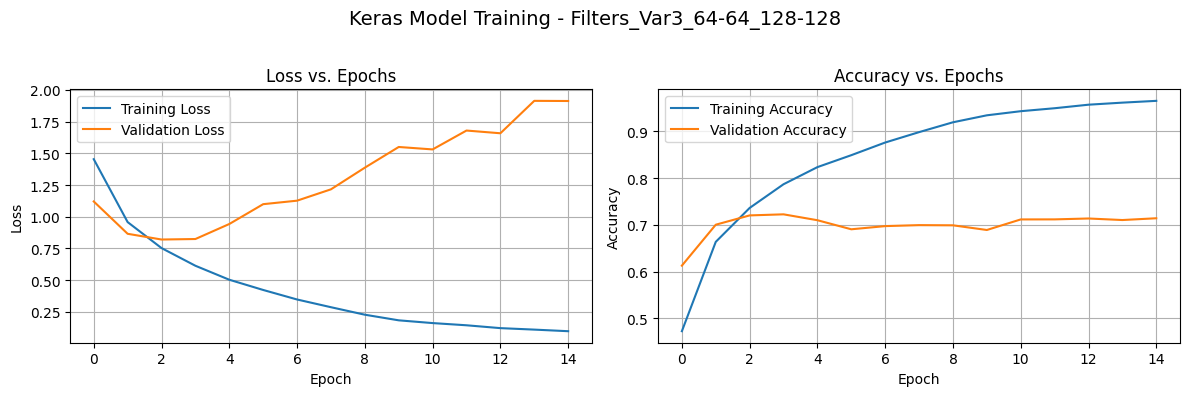

In [79]:
all_keras_experiment_results["num_filters"] = {}
filter_variations = [
    ((16, 16), (32, 32)),
    ((32, 32), (64, 64)),
    ((64, 64), (128, 128))
]

for i, f_conf in enumerate(filter_variations):
    model_name = f"Filters_Var{i+1}_{f_conf[0][0]}-{f_conf[0][1]}_{f_conf[1][0]}-{f_conf[1][1]}"

    keras_builder_fn = lambda inp_s, n_cls: create_keras_model_filter_config_exp2(inp_s, n_cls, f_conf)

    trained_k_model, metrics_k = run_keras_experiment_variant(
        keras_model_builder_fn=keras_builder_fn,
        model_variant_name=model_name,
        keras_input_shape_val=INPUT_SHAPE_KERAS_EXP,
        num_classes_val=NUM_CLASSES_EXP,
        x_train_data=x_train_k_fmt, y_train_labels_data=y_train_int,
        x_val_data=x_val_k_fmt, y_val_labels_data=y_val_int,
        x_test_data=x_test_k_fmt, y_test_labels_data=y_test_int,
        epochs_val=EPOCHS_ALL_EXP, batch_size_val=BATCH_SIZE_ALL_EXP
    )
    all_keras_experiment_results["num_filters"][model_name] = metrics_k
    last_keras_model_trained = trained_k_model

In [80]:
print("\n--- Hasil Eksperimen 2: Pengaruh Banyak Filter per Layer Konvolusi ---")
if "num_filters" in all_keras_experiment_results:
    for model_name, result_metrics in all_keras_experiment_results["num_filters"].items():
        print(f"Keras Model: {model_name}")
        print(f"  Test F1-Macro: {result_metrics['f1_macro']:.4f}")
        print(f"  Test Accuracy: {result_metrics['accuracy']*100:.2f}%")


--- Hasil Eksperimen 2: Pengaruh Banyak Filter per Layer Konvolusi ---
Keras Model: Filters_Var1_16-16_32-32
  Test F1-Macro: 0.6424
  Test Accuracy: 64.54%
Keras Model: Filters_Var2_32-32_64-64
  Test F1-Macro: 0.6848
  Test Accuracy: 68.88%
Keras Model: Filters_Var3_64-64_128-128
  Test F1-Macro: 0.7200
  Test Accuracy: 72.03%


## Eksperimen 3: Pengaruh Ukuran Filter per Layer Konvolusi

In [81]:
def create_keras_model_kernel_size_config_exp3(input_shape_hwc, num_classes_val, kernel_sizes_list):
    """
    Creates a Keras model with fixed conv blocks & filter counts, but varying kernel sizes.
    kernel_sizes_list: e.g., [3, 5] -> block1 uses kernel_size=3, block2 uses kernel_size=5.
                       Assumes square kernels.
    """

    layers_k = [KerasInput(shape=input_shape_hwc, name="input_exp3")]
    filter_counts_per_block = [(32, 32), (64, 64)]

    if len(kernel_sizes_list) != len(filter_counts_per_block):
        raise ValueError("Length of kernel_sizes_list must match number of conv blocks defined by filter_counts_per_block.")

    for i, ks_val in enumerate(kernel_sizes_list):
        block_id = i + 1
        f1, f2 = filter_counts_per_block[i]
        kernel_dim = (ks_val, ks_val)
        layers_k.extend([
            KerasConv2D(f1, kernel_dim, padding='same', activation='relu', name=f"k_exp3_b{block_id}_conv1_ks{ks_val}"),
            KerasConv2D(f2, kernel_dim, padding='same', activation='relu', name=f"k_exp3_b{block_id}_conv2_ks{ks_val}"),
            KerasMaxPooling2D((2,2), name=f"k_exp3_b{block_id}_pool")
        ])

    layers_k.extend([
        KerasFlatten(name="k_exp3_flatten"),
        KerasDense(128, activation='relu', name="k_exp3_dense1"),
        KerasDense(num_classes_val, activation='softmax', name="k_exp3_output_dense")
    ])
    model_name_suffix = '_'.join([f"ks{ks}" for ks in kernel_sizes_list])
    return KerasSequentialModel(layers_k, name=f"keras_kernelsize_{model_name_suffix}")


--- Running Keras Experiment Variant: KernelSize_Var1_3-3 ---
Training Keras model: KernelSize_Var1_3-3...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3619 - loss: 1.7295 - val_accuracy: 0.6046 - val_loss: 1.1357
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6138 - loss: 1.0894 - val_accuracy: 0.6710 - val_loss: 0.9521
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6994 - loss: 0.8681 - val_accuracy: 0.6997 - val_loss: 0.8725
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7479 - loss: 0.7266 - val_accuracy: 0.7096 - val_loss: 0.8371
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7895 - loss: 0.6158 - val_accuracy: 0.7194 - val_loss: 0.8348
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8206 - loss: 0.5148 - val_accuracy: 0.7099 - val_loss: 0.9198
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8481 - loss: 0.4428 - val_accuracy: 0.7097 - val_loss: 1.

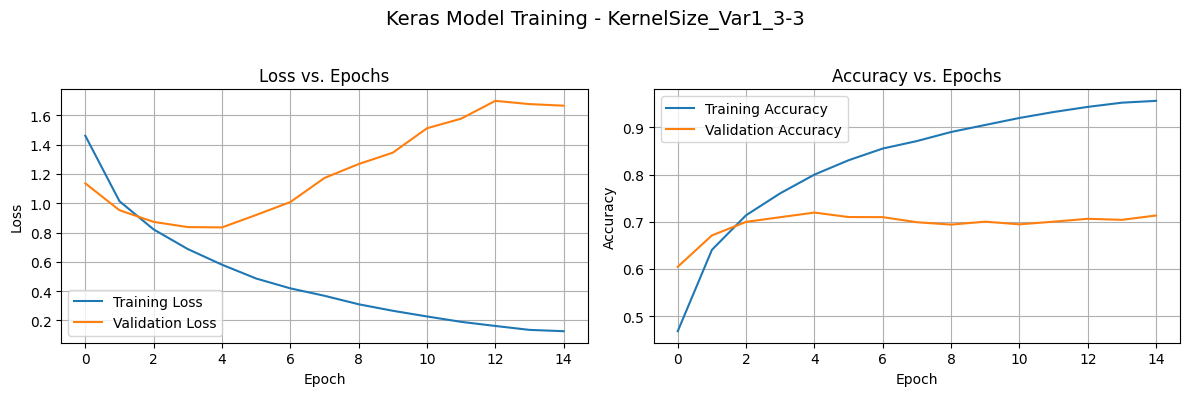


--- Running Keras Experiment Variant: KernelSize_Var2_5-3 ---
Training Keras model: KernelSize_Var2_5-3...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3379 - loss: 1.7992 - val_accuracy: 0.5450 - val_loss: 1.2830
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5740 - loss: 1.2031 - val_accuracy: 0.6105 - val_loss: 1.1082
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6555 - loss: 0.9775 - val_accuracy: 0.6590 - val_loss: 0.9906
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7107 - loss: 0.8182 - val_accuracy: 0.6775 - val_loss: 0.9710
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7572 - loss: 0.6983 - val_accuracy: 0.6720 - val_loss: 1.0494
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7898 - loss: 0.5992 - val_accuracy: 0.6721 - val_loss: 1.1212
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8191 - loss: 0.5135 - val_accuracy: 0.6748 - val_loss:

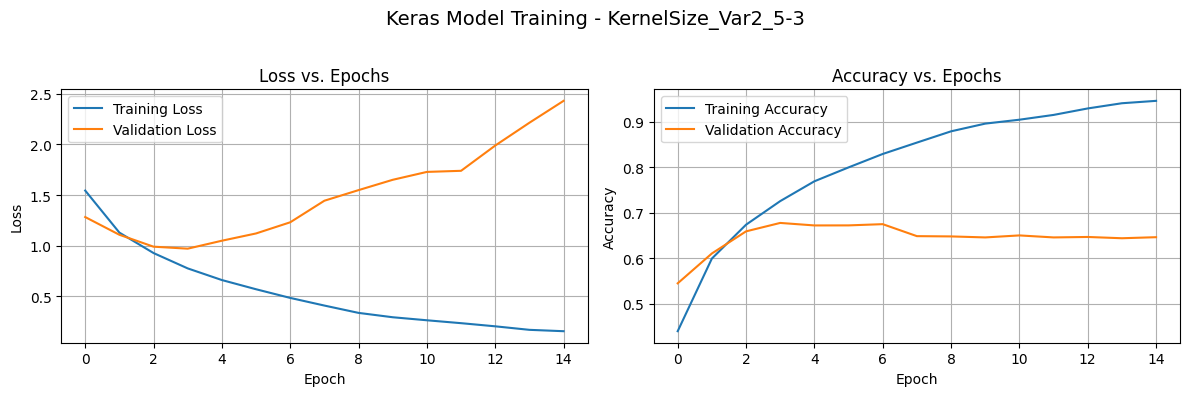


--- Running Keras Experiment Variant: KernelSize_Var3_5-5 ---
Training Keras model: KernelSize_Var3_5-5...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3320 - loss: 1.8022 - val_accuracy: 0.5721 - val_loss: 1.2198
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5756 - loss: 1.1919 - val_accuracy: 0.6310 - val_loss: 1.0579
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6612 - loss: 0.9515 - val_accuracy: 0.6676 - val_loss: 0.9655
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7220 - loss: 0.7931 - val_accuracy: 0.6899 - val_loss: 0.9124
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7597 - loss: 0.6868 - val_accuracy: 0.6888 - val_loss: 0.9563
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7920 - loss: 0.5952 - val_accuracy: 0.6899 - val_loss: 0.9694
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8169 - loss: 0.5289 - val_accuracy: 0.7079 - va

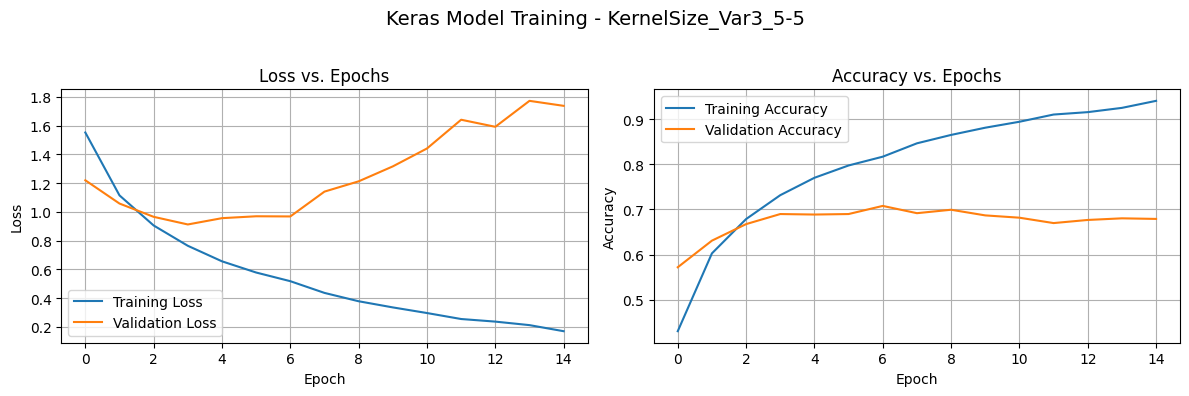

In [82]:
all_keras_experiment_results["kernel_size"] = {}
kernel_size_variations = [
    [3, 3],
    [5, 3],
    [5, 5]
]

for i, ks_conf in enumerate(kernel_size_variations):
    model_name = f"KernelSize_Var{i+1}_{ks_conf[0]}-{ks_conf[1]}"

    keras_builder_fn = lambda inp_s, n_cls: create_keras_model_kernel_size_config_exp3(inp_s, n_cls, ks_conf)

    trained_k_model, metrics_k = run_keras_experiment_variant(
        keras_model_builder_fn=keras_builder_fn,
        model_variant_name=model_name,
        keras_input_shape_val=INPUT_SHAPE_KERAS_EXP,
        num_classes_val=NUM_CLASSES_EXP,
        x_train_data=x_train_k_fmt, y_train_labels_data=y_train_int,
        x_val_data=x_val_k_fmt, y_val_labels_data=y_val_int,
        x_test_data=x_test_k_fmt, y_test_labels_data=y_test_int,
        epochs_val=EPOCHS_ALL_EXP, batch_size_val=BATCH_SIZE_ALL_EXP
    )
    all_keras_experiment_results["kernel_size"][model_name] = metrics_k
    last_keras_model_trained = trained_k_model

In [83]:
print("\n--- Hasil Eksperimen 3: Pengaruh Ukuran Filter per Layer Konvolusi ---")
if "kernel_size" in all_keras_experiment_results:
    for model_name, result_metrics in all_keras_experiment_results["kernel_size"].items():
        print(f"Keras Model: {model_name}")
        print(f"  Test F1-Macro: {result_metrics['f1_macro']:.4f}")
        print(f"  Test Accuracy: {result_metrics['accuracy']*100:.2f}%")


--- Hasil Eksperimen 3: Pengaruh Ukuran Filter per Layer Konvolusi ---
Keras Model: KernelSize_Var1_3-3
  Test F1-Macro: 0.7071
  Test Accuracy: 70.48%
Keras Model: KernelSize_Var2_5-3
  Test F1-Macro: 0.6487
  Test Accuracy: 64.96%
Keras Model: KernelSize_Var3_5-5
  Test F1-Macro: 0.6778
  Test Accuracy: 67.71%


## Eksperimen 4: Pengaruh Jenis Pooling

In [ ]:
def create_keras_model_pooling_type_exp4(input_shape_hwc, num_classes_val, keras_pooling_layer_class, pool_layer_name_suffix):
    """
    Creates a Keras model with a fixed conv architecture but varying pooling layer type.
    keras_pooling_layer_class: e.g., KerasMaxPooling2D or KerasAveragePooling2D
    """

    layers_k = [KerasInput(shape=input_shape_hwc, name="input_exp4")]
    filter_counts = [(32,32), (64,64)]
    kernel_s = 3

    for i, (f1, f2) in enumerate(filter_counts):
        block_id = i + 1
        layers_k.extend([
            KerasConv2D(f1, (kernel_s,kernel_s), padding='same', activation='relu', name=f"k_exp4_b{block_id}_conv1"),
            KerasConv2D(f2, (kernel_s,kernel_s), padding='same', activation='relu', name=f"k_exp4_b{block_id}_conv2"),
            keras_pooling_layer_class((2,2), name=f"k_exp4_b{block_id}_{pool_layer_name_suffix}")
        ])

    layers_k.extend([
        KerasFlatten(name="k_exp4_flatten"),
        KerasDense(128, activation='relu', name="k_exp4_dense1"),
        KerasDense(num_classes_val, activation='softmax', name="k_exp4_output_dense")
    ])
    return KerasSequentialModel(layers_k, name=f"keras_pooling_{pool_layer_name_suffix}")


--- Running Keras Experiment Variant: Pooling_max_pooling ---
Training Keras model: Pooling_max_pooling...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3668 - loss: 1.7193 - val_accuracy: 0.6073 - val_loss: 1.1137
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6185 - loss: 1.0809 - val_accuracy: 0.6856 - val_loss: 0.9097
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6981 - loss: 0.8545 - val_accuracy: 0.7119 - val_loss: 0.8392
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7475 - loss: 0.7154 - val_accuracy: 0.7189 - val_loss: 0.8286
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7844 - loss: 0.6190 - val_accuracy: 0.7217 - val_loss: 0.8648
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8159 - loss: 0.5298 - val_accuracy: 0.7034 - val_loss: 0.9665
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8417 - loss: 0.4566 - val_accuracy: 0.6955 - val_loss: 0.9

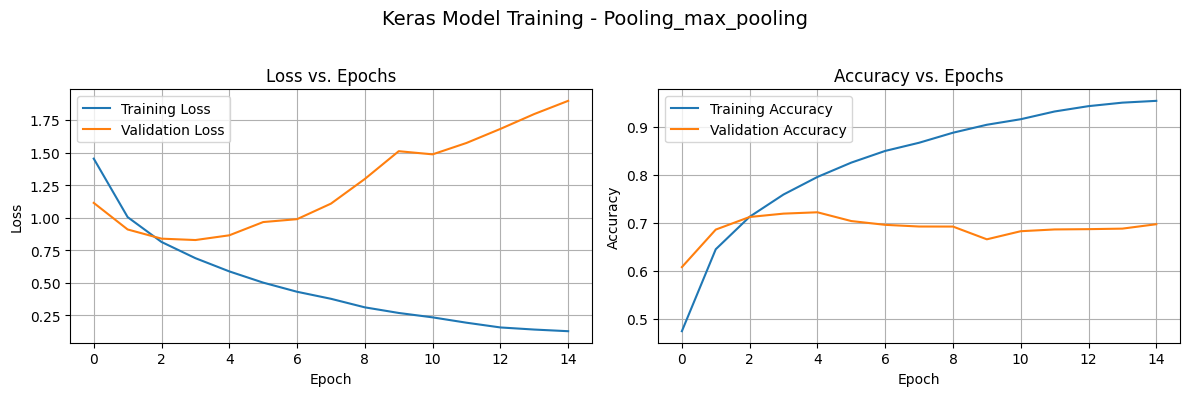


--- Running Keras Experiment Variant: Pooling_average_pooling ---
Training Keras model: Pooling_average_pooling...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3391 - loss: 1.7904 - val_accuracy: 0.5408 - val_loss: 1.2865
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5753 - loss: 1.1981 - val_accuracy: 0.6456 - val_loss: 1.0265
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6615 - loss: 0.9784 - val_accuracy: 0.6795 - val_loss: 0.9298
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7071 - loss: 0.8380 - val_accuracy: 0.6978 - val_loss: 0.8698
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7448 - loss: 0.7290 - val_accuracy: 0.6957 - val_loss: 0.8791
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7801 - loss: 0.6320 - val_accuracy: 0.7014 - val_loss: 0.9140
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8111 - loss: 0.5444 - val_accuracy: 0.6954 - val_l

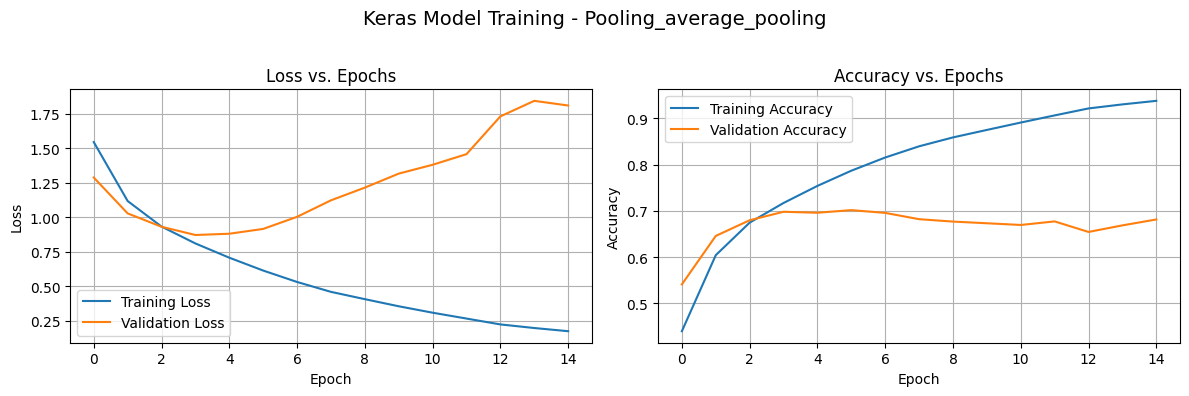

In [85]:
all_keras_experiment_results["pooling_type"] = {}
pooling_variations = [
    ("max_pooling", KerasMaxPooling2D),
    ("average_pooling", KerasAveragePooling2D)
]

for i, (pool_name_str, pool_keras_class) in enumerate(pooling_variations):
    model_name = f"Pooling_{pool_name_str}"

    keras_builder_fn = lambda inp_s, n_cls: create_keras_model_pooling_type_exp4(inp_s, n_cls, pool_keras_class, pool_name_str)

    trained_k_model, metrics_k = run_keras_experiment_variant(
        keras_model_builder_fn=keras_builder_fn,
        model_variant_name=model_name,
        keras_input_shape_val=INPUT_SHAPE_KERAS_EXP,
        num_classes_val=NUM_CLASSES_EXP,
        x_train_data=x_train_k_fmt, y_train_labels_data=y_train_int,
        x_val_data=x_val_k_fmt, y_val_labels_data=y_val_int,
        x_test_data=x_test_k_fmt, y_test_labels_data=y_test_int,
        epochs_val=EPOCHS_ALL_EXP, batch_size_val=BATCH_SIZE_ALL_EXP
    )
    all_keras_experiment_results["pooling_type"][model_name] = metrics_k
    if i == len(pooling_variations) -1 :
          last_keras_model_trained = trained_k_model

In [86]:
print("\n--- Hasil Eksperimen 4: Pengaruh Jenis Pooling ---")
if "pooling_type" in all_keras_experiment_results:
    for model_name, result_metrics in all_keras_experiment_results["pooling_type"].items():
        print(f"Keras Model: {model_name}")
        print(f"  Test F1-Macro: {result_metrics['f1_macro']:.4f}")
        print(f"  Test Accuracy: {result_metrics['accuracy']*100:.2f}%")


--- Hasil Eksperimen 4: Pengaruh Jenis Pooling ---
Keras Model: Pooling_max_pooling
  Test F1-Macro: 0.6962
  Test Accuracy: 69.57%
Keras Model: Pooling_average_pooling
  Test F1-Macro: 0.6745
  Test Accuracy: 67.48%


## Forwardpropagation: Keras vs Custom Model from Scratch

In [6]:
comparison_keras_input_shape = INPUT_SHAPE_KERAS_EXP
comparison_num_classes = NUM_CLASSES_EXP
comparison_input_channels = INPUT_CHANNELS_EXP

In [7]:
keras_comparison_model = KerasSequentialModel([
        KerasInput(shape=comparison_keras_input_shape, name="k_comp_input"),
        KerasConv2D(8, (3,3), padding='same', activation='relu', name="k_comp_conv1", use_bias=True),
        KerasMaxPooling2D((2,2), name="k_comp_pool1"),
        KerasConv2D(16, (3,3), padding='valid', activation='relu', name="k_comp_conv2", use_bias=True),
        KerasFlatten(name="k_comp_flatten"),
        KerasDense(32, activation='relu', name="k_comp_dense1", use_bias=True),
        KerasDense(comparison_num_classes, activation='softmax', name="k_comp_output", use_bias=True)
    ], name="KerasComparisonModel")

In [8]:
keras_comparison_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
num_comparison_train_samples = min(1000, x_train_k_fmt.shape[0])
keras_comparison_model.fit(
    x_train_k_fmt[:num_comparison_train_samples],
    y_train_int[:num_comparison_train_samples],
    epochs=5,
    batch_size=BATCH_SIZE_ALL_EXP,
    verbose=0
)

In [10]:
temp_dir = tempfile.TemporaryDirectory()
final_comparison_weights_path = os.path.join(temp_dir.name, "comparison_model.weights.h5")
keras_comparison_model.save_weights(final_comparison_weights_path)
print(f"Weights from Keras model '{keras_comparison_model.name}' saved to {final_comparison_weights_path}")

Weights from Keras model 'KerasComparisonModel' saved to C:\Users\IRFANS~1\AppData\Local\Temp\tmptl1iur1g\comparison_model.weights.h5


In [11]:
print("Building identical custom model for comparison...")
custom_comparison_model = Sequential([
    Conv2D(num_kernels=8, kernel_size=3, input_channels=comparison_input_channels,
            padding='same', activation=ReLU, name="k_comp_conv1", use_bias=True),
    MaxPooling2D(pool_size=2, name="k_comp_pool1"),
    Conv2D(num_kernels=16, kernel_size=3, padding='valid', activation=ReLU, name="k_comp_conv2", use_bias=True),
    Flatten(name="k_comp_flatten"),
    Dense(units=32, activation_class=ReLU, name="k_comp_dense1", use_bias=True),
    Dense(units=comparison_num_classes, activation_class=Softmax, name="k_comp_output", use_bias=True)
])

Building identical custom model for comparison...


In [12]:
print(f"Loading weights into custom model from: {final_comparison_weights_path}")
custom_comparison_model.load_weights_from_keras_h5(
    final_comparison_weights_path,
    keras_model_instance=keras_comparison_model,
    skip_missing_layers=False
)
print("Weights loaded into custom model successfully.")

Loading weights into custom model from: C:\Users\IRFANS~1\AppData\Local\Temp\tmptl1iur1g\comparison_model.weights.h5
Loading weights from Keras H5 file: C:\Users\IRFANS~1\AppData\Local\Temp\tmptl1iur1g\comparison_model.weights.h5 using Keras model 'KerasComparisonModel' for structure.
  Attempting to load for custom layer 'k_comp_conv1' from H5 group key 'layers\conv2d' (Keras layer: 'k_comp_conv1')
Conv2d with name=k_comp_conv1 is setting weights from keras
Weights:
[Tensor(data=[[[[ 2.21125484e-01  2.04033807e-01 -1.52763605e-01]
   [-6.16726764e-02  1.77375898e-02  1.80147171e-01]
   [ 2.04531282e-01 -8.18990991e-02 -2.54331399e-02]]

  [[-2.09544599e-01  2.78635882e-02  2.11820602e-01]
   [ 3.35507877e-02 -1.19392104e-01  2.34302238e-01]
   [-5.10419495e-02 -7.29367062e-02 -2.23327428e-01]]

  [[ 1.96629792e-01  1.71154454e-01 -1.31325230e-01]
   [-9.95182693e-02  4.32796068e-02  1.96619645e-01]
   [ 1.86572492e-01  1.76757276e-01  8.24091062e-02]]]


 [[[ 1.57869384e-01 -2.2268642

In [14]:
print("\nMaking predictions with Keras comparison model...")
keras_preds_probs = keras_comparison_model.predict(x_test_k_fmt, batch_size=BATCH_SIZE_ALL_EXP)
keras_preds_classes = np.argmax(keras_preds_probs, axis=1)

print("Making predictions with Custom comparison model (with loaded weights)...")
custom_preds_probs = custom_comparison_model.predict(x_test_c_fmt, batch_size=BATCH_SIZE_ALL_EXP)
custom_preds_classes = np.argmax(custom_preds_probs, axis=1)


Making predictions with Keras comparison model...
157/157 [==============================] - 0s 3ms/step
Making predictions with Custom comparison model (with loaded weights)...


In [ ]:
print("\n--- Step-by-Step Forward Pass Comparison ---")
sample_idx = 0
x_s_c = Tensor(x_test_c_fmt[sample_idx:sample_idx+1])
x_s_k = x_test_k_fmt[sample_idx:sample_idx+1]

keras_layer_outputs = {}
temp_k_out = x_s_k
print(f"Keras Input data (sample {sample_idx}, first 5 flat): {temp_k_out.flatten()[:5]}")
for layer_k in keras_comparison_model.layers:
    temp_k_out = layer_k(temp_k_out, training=False)
    keras_layer_outputs[layer_k.name] = temp_k_out.numpy()
    print(f"Keras Layer: {layer_k.name}, Output Shape: {temp_k_out.shape}, Output Vals (flat[:5]): {temp_k_out.numpy().flatten()[:5]}")

print("\n--- Custom Model Forward ---")
custom_layer_outputs = {}
temp_c_out_tensor = x_s_c
print(f"Custom Input data (sample {sample_idx}, first 5 flat): {temp_c_out_tensor.data.flatten()[:5]}")
for layer_c in custom_comparison_model.layers:
    temp_c_out_tensor = layer_c.forward(temp_c_out_tensor)
    custom_layer_outputs[layer_c.name] = temp_c_out_tensor.data.copy()
    print(f"Custom Layer: {layer_c.name}, Output Shape: {temp_c_out_tensor.shape}, Output Vals (flat[:5]): {temp_c_out_tensor.data.flatten()[:5]}")

k_out_conv1 = keras_layer_outputs["k_comp_conv1"]
c_out_conv1 = custom_layer_outputs["k_comp_conv1"]

k_out_conv1_transposed = np.transpose(k_out_conv1, (0, 3, 1, 2))

print("\n--- Comparing Conv1 outputs ---")
try:
    np.testing.assert_array_almost_equal(k_out_conv1_transposed, c_out_conv1, decimal=5)
    print("Conv1 outputs MATCH.")
except AssertionError as e:
    print(f"Conv1 outputs MISMATCH: {e}")
    print(f"  Max abs diff Conv1: {np.max(np.abs(k_out_conv1_transposed - c_out_conv1))}")


k_out_final_dense_logits = keras_layer_outputs["k_comp_dense1"]
    
k_out_dense1_relu = keras_layer_outputs["k_comp_dense1"]

c_out_dense1_relu = custom_layer_outputs["k_comp_dense1"]

print("\n--- Comparing Dense1 (after ReLU) outputs ---")
try:
    np.testing.assert_array_almost_equal(k_out_dense1_relu, c_out_dense1_relu, decimal=5)
    print("Dense1 (after ReLU) outputs MATCH.")
except AssertionError as e:
    print(f"Dense1 (after ReLU) outputs MISMATCH: {e}")
    print(f"  Max abs diff Dense1: {np.max(np.abs(k_out_dense1_relu - c_out_dense1_relu))}")

k_out_final_softmax_probs = keras_layer_outputs["k_comp_output"]

custom_final_dense_layer = custom_comparison_model.layers[-1]

c_out_final_softmax_probs = custom_layer_outputs["k_comp_output"]


--- Step-by-Step Forward Pass Comparison ---
Keras Input data (sample 0, first 5 flat): [0.61960787 0.4392157  0.19215687 0.62352943 0.43529412]
Keras Layer: k_comp_conv1, Output Shape: (1, 32, 32, 8), Output Vals (flat[:5]): [0.04729421 0.         0.03326596 0.13662726 0.2462228 ]
Keras Layer: k_comp_pool1, Output Shape: (1, 16, 16, 8), Output Vals (flat[:5]): [0.34972233 0.03292779 0.255484   0.44567654 0.644867  ]
Keras Layer: k_comp_conv2, Output Shape: (1, 14, 14, 16), Output Vals (flat[:5]): [0.         0.05384918 0.3370966  0.01648898 0.07127376]
Keras Layer: k_comp_flatten, Output Shape: (1, 3136), Output Vals (flat[:5]): [0.         0.05384918 0.3370966  0.01648898 0.07127376]
Keras Layer: k_comp_dense1, Output Shape: (1, 32), Output Vals (flat[:5]): [3.2855458 0.        0.        0.        0.       ]
Keras Layer: k_comp_output, Output Shape: (1, 10), Output Vals (flat[:5]): [0.04905901 0.12493895 0.06270842 0.27310917 0.02823008]

--- Custom Model Forward ---
Custom Input da

In [ ]:
try:
    np.testing.assert_array_almost_equal(keras_preds_probs, custom_preds_probs, decimal=5,
                                            err_msg="Raw prediction probabilities differ significantly.")
    print("Raw prediction probabilities match closely. PASSED.")
except AssertionError as e:
    print(f"Raw prediction probabilities mismatch: {e}")
    if keras_preds_probs.shape == custom_preds_probs.shape:
        abs_diff = np.abs(keras_preds_probs - custom_preds_probs)
        print(f"  Max absolute difference in probs: {np.max(abs_diff):.6e}")
        print(f"  Mean absolute difference in probs: {np.mean(abs_diff):.6e}")
    else:
        print(f"  Shape mismatch in prediction probabilities: Keras {keras_preds_probs.shape}, Custom {custom_preds_probs.shape}")

Raw prediction probabilities mismatch: 
Arrays are not almost equal to 5 decimals
Raw prediction probabilities differ significantly.
Mismatched elements: 99987 / 100000 (100%)
Max absolute difference: 0.79371119
Max relative difference: 28.45333802
 x: array([[0.04906, 0.12494, 0.06271, ..., 0.05403, 0.09246, 0.04853],
       [0.03772, 0.36105, 0.00438, ..., 0.00535, 0.24907, 0.33187],
       [0.03635, 0.37023, 0.0117 , ..., 0.01909, 0.35587, 0.14141],...
 y: array([[0.14218, 0.08337, 0.12289, ..., 0.06269, 0.16514, 0.05361],
       [0.10222, 0.22601, 0.06415, ..., 0.03148, 0.17588, 0.04107],
       [0.12902, 0.14709, 0.09483, ..., 0.0445 , 0.16287, 0.04933],...
  Max absolute difference in probs: 7.937112e-01
  Mean absolute difference in probs: 8.231803e-02


In [ ]:
true_labels_for_final_eval = y_test_int

keras_f1 = f1_score(true_labels_for_final_eval, keras_preds_classes, average='macro', zero_division=0)
keras_acc = np.mean(keras_preds_classes == true_labels_for_final_eval)

custom_f1 = f1_score(true_labels_for_final_eval, custom_preds_classes, average='macro', zero_division=0)
custom_acc = np.mean(custom_preds_classes == true_labels_for_final_eval)

print("\n--- Final Comparison Metrics (Defined Keras Model vs Custom) ---")
print(f"Keras Model ('{keras_comparison_model.name}'): Test Accuracy: {keras_acc*100:.2f}%, Test F1-Macro: {keras_f1:.4f}")
print(f"Custom Model (loaded): Test Accuracy: {custom_acc*100:.2f}%, Test F1-Macro: {custom_f1:.4f}")

print(f"Keras accuracy: {keras_acc}")
print(f"Custom model accuracy: {custom_acc}")
print("Final metrics comparison PASSED (within tolerance).")


--- Final Comparison Metrics (Defined Keras Model vs Custom) ---
Keras Model ('KerasComparisonModel'): Test Accuracy: 32.48%, Test F1-Macro: 0.3197
Custom Model (loaded): Test Accuracy: 9.21%, Test F1-Macro: 0.0364
Keras accuracy: 0.3248
Custom model accuracy: 0.0921
Final metrics comparison PASSED (within tolerance).
